In [1]:
import h5py
from data_analysis_codes import param
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools import LinData
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
from data_analysis_codes.tools import GetVars_Plot2d as GVar
import ebweyl as ebw
from matplotlib import gridspec
import matplotlib

from data_analysis_codes.tools import ReadingTools as RRead
from skimage import measure
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sim = param.pflrw_d3e2_L1821_t1_N64_LCDM()
Lin = LinData.LinData_Class(sim, '/home/robynm/simulations/'+sim.sim_name+'/')

 read time file


In [3]:
it = 10000
it_file_name = '/home/robynm/simulations/'+sim.sim_name+'/output-0000/'+sim.parfile_name+'/'+'all_iterations/'+sim.sim_name
f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r')

In [4]:
f.keys()

<KeysViewHDF5 ['ADMBASE::gxx it=10000 tl=0 rl=0', 'ADMBASE::gxy it=10000 tl=0 rl=0', 'ADMBASE::gxz it=10000 tl=0 rl=0', 'ADMBASE::gyy it=10000 tl=0 rl=0', 'ADMBASE::gyz it=10000 tl=0 rl=0', 'ADMBASE::gzz it=10000 tl=0 rl=0', 'ADMBASE::kxx it=10000 tl=0 rl=0', 'ADMBASE::kxy it=10000 tl=0 rl=0', 'ADMBASE::kxz it=10000 tl=0 rl=0', 'ADMBASE::kyy it=10000 tl=0 rl=0', 'ADMBASE::kyz it=10000 tl=0 rl=0', 'ADMBASE::kzz it=10000 tl=0 rl=0', 'B2', 'CT_DUST::rho it=10000 tl=0 rl=0', 'E2', 'RicciS', 'delta']>

In [5]:
def call(k):
    rest = ' it='+str(it)+' tl=0 rl=0'
    try:
        return np.array(f['ADMBASE::'+k+rest])
    except:
        return np.array(f['CT_DUST::'+k+rest])

In [6]:
Box_1 = np.ones((Lin.N, Lin.N, Lin.N))
Box_0 = np.zeros((Lin.N, Lin.N, Lin.N))
gdown4 = np.array([[-Box_1, Box_0, Box_0, Box_0],
                   [Box_0, call('gxx'), call('gxy'), call('gxz')],
                   [Box_0, call('gxy'), call('gyy'), call('gyz')],
                   [Box_0, call('gxz'), call('gyz'), call('gzz')]])
Kdown4 = np.array([[Box_0, Box_0, Box_0, Box_0],
                   [Box_0, call('kxx'), call('kxy'), call('kxz')],
                   [Box_0, call('kxy'), call('kyy'), call('kyz')],
                   [Box_0, call('kxz'), call('kyz'), call('kzz')]])
Tdown4 = np.array([[-call('rho'), Box_0, Box_0, Box_0],
                   [Box_0, Box_0, Box_0, Box_0],
                   [Box_0, Box_0, Box_0, Box_0],
                   [Box_0, Box_0, Box_0, Box_0]])
del Box_1, Box_0, f

In [7]:
def abreal(a):
    return abs(np.real(a))
def abim(a):
    return abs(np.imag(a))

In [ ]:
FD = ebw.FiniteDifference(sim.dx, Lin.N)
EBW = ebw.Weyl(FD, gdown4, Kdown4)
del gdown4, Kdown4
Gudd3 = EBW.christoffel_symbol_udd3()
RicciTdown3 = EBW.ricci_tensor_down3(Gudd3)
Bndown3 = EBW.bweyl_n_tensor_down3(Gudd3)
del Gudd3
Endown3 = EBW.eweyl_n_tensor_down3(RicciTdown3, Lin.kappa, Tdown4)
del RicciTdown3, Tdown4
Cdown4 = EBW.weyl_tensor_down4(Endown3, Bndown3)
Enorm = EBW.norm_rank2tensor3(Endown3)
Bnorm = EBW.norm_rank2tensor3(Bndown3)
del Endown3, Bndown3
Psis = EBW.weyl_psi_scalars(Cdown4)
del Cdown4
invars = EBW.invariant_scalars(Psis)
del Psis

In [ ]:
H = Lin.temp_from_temp('H', 'it', it)
iH2 = 1/(H*H)

I = invars['I']
J = invars['J']
dI = I**(1/2)
dJ = J**(1/3)
dK = invars['K']**(1/3)
dL = invars['L']**(1/2)
dN = invars['N']**(1/4)
dScrit = (I*I*I-27*J*J)**(1/6)
    
dE = Enorm*iH2
dB = Bnorm*iH2
    
dIr = abreal(dI)*iH2
dIc = abim(dI)*iH2
dJr = abreal(dJ)*iH2
dJc = abim(dJ)*iH2
dScritr = abreal(dScrit)*iH2
dScritc = abim(dScrit)*iH2
dLSr = abreal(dL)*iH2
dLSc = abim(dL)*iH2
dKr = abreal(dK)*iH2
dKc = abim(dK)*iH2
dNr = abreal(dN)*iH2
dNc = abim(dN)*iH2
    
Petrov_class = np.zeros(np.shape(I))

In [10]:
for ix in range(Lin.N):
    for iy in range(Lin.N):
        for iz in range(Lin.N):
            cutoff = 0.2
            if dScritr[ix,iy,iz]<cutoff and dScritc[ix,iy,iz]<cutoff:
                cutoff = 0.05
                Ireq0 = dIr[ix,iy,iz]<cutoff and dIc[ix,iy,iz]<cutoff
                Jreq0 = dJr[ix,iy,iz]<cutoff and dJc[ix,iy,iz]<cutoff
                if Ireq0 and Jreq0:
                    cutoff = 0.025
                    Kreq0 = dKr[ix,iy,iz]<cutoff and dKc[ix,iy,iz]<cutoff
                    LSreq0 = dLSr[ix,iy,iz]<cutoff and dLSc[ix,iy,iz]<cutoff
                    if Kreq0 and LSreq0:
                        cutoff = 0.01
                        if dE[ix,iy,iz]<cutoff and dB[ix,iy,iz]<cutoff:
                            Petrov_class[ix,iy,iz]=6 #type O
                        else:
                            Petrov_class[ix,iy,iz]=5 #type N
                    else:
                        Petrov_class[ix,iy,iz]=4 #type III
                else:
                    cutoff = 0.025
                    Kreq0 = dKr[ix,iy,iz]<cutoff and dKc[ix,iy,iz]<cutoff
                    Nreq0 = dNr[ix,iy,iz]<cutoff and dNc[ix,iy,iz]<cutoff
                    if Kreq0 and Nreq0:
                         Petrov_class[ix,iy,iz]=3 #type D
                    else:
                        Petrov_class[ix,iy,iz]=2 #type II
            else:
                Petrov_class[ix,iy,iz]=1 #type I

In [11]:
Petrov_class

array([[[5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.]],

       [[5., 5., 5., ..., 4., 4., 4.],
        [5., 5., 5., ..., 4., 4., 4.],
        [4., 5., 5., ..., 4., 4., 4.],
        ...,
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 4., 4., 5.],
        [5., 5., 5., ..., 4., 4., 5.]],

       ...,

       [[5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5., 5.],
        [5., 5., 5., ..., 5., 5.

In [12]:
def plotformat():
    A = -sim.lambda_pert/4
    B = sim.lambda_pert/2
    
    ax.plot([A, A], [A, B], [A, A], 'w', zorder=3)
    ax.plot([A, A], [A, A], [A, B], 'w', zorder=3)
    ax.plot([A, B], [A, A], [A, A], 'w', zorder=3)
    ax.plot([A, B], [A, B], [A, A], 'w-.', zorder=3)
    ax.plot([A, A], [A, B], [A, B], 'w-.', zorder=3)
    ax.plot([A, B], [A, A], [A, B], 'w-.', zorder=3)
    ax.plot([B,A,A,A,B,B,B], [A,A,B,B,B,A,A], [B,B,B,A,A,A,B], 'w', zorder=3, linewidth=0.25)
    ax.plot([B,B], [-B,A], [B,B], 'w', zorder=3, linewidth=0.25)
    ax.plot([-B,A], [B,B], [B,B], 'w', zorder=3, linewidth=0.25)
    ax.plot([B,B], [B,B], [-B,A], 'w', zorder=3, linewidth=0.25)
    
    ticks = [-sim.lambda_pert/2, -sim.lambda_pert/4, 0, sim.lambda_pert/4, sim.lambda_pert/2]
    tickm = [-0.5, -0.25, 0.0, 0.25, 0.5]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    ax.set_xticklabels(tickm)
    ax.set_yticklabels(tickm)
    ax.set_zticklabels(tickm)
    ax.set_xlabel(r'$x \;\; [\lambda_{pert}]$')
    ax.set_ylabel(r'$y \;\; [\lambda_{pert}]$')
    ax.set_zlabel(r'$z \;\; [\lambda_{pert}]$')
    ax.view_init(30,30)

In [14]:
np.min(Petrov_class),np.max(Petrov_class)

(2.0, 5.0)

<IPython.core.display.Javascript object>


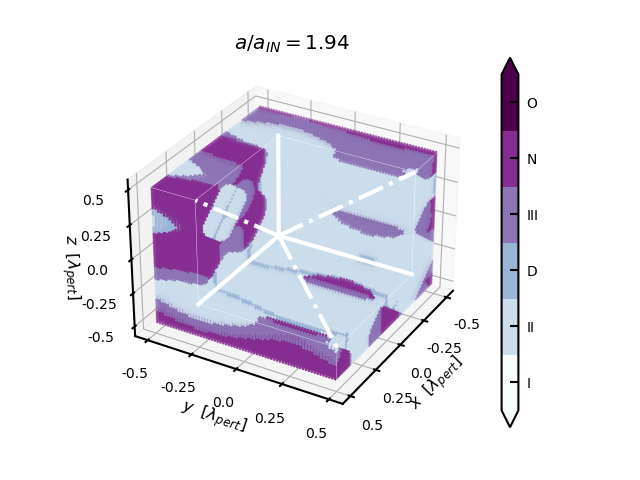

<ipython-input-15-79fa3aa3ee24>:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


In [15]:
data = Petrov_class
fig = plt.figure()
gs = gridspec.GridSpec(1, 1) 
ax = fig.add_subplot(gs[0], projection='3d')
cmap = plt.cm.get_cmap('BuPu', 6)
mask = ~ np.logical_and(np.logical_and(Lin.d3x>-sim.lambda_pert/4, Lin.d3y>-sim.lambda_pert/4), Lin.d3z>-sim.lambda_pert/4)
scatter = ax.scatter(Lin.d3x[mask], Lin.d3y[mask], Lin.d3z[mask], c=data[mask], s=1, cmap=cmap, zorder=1, vmin=0.5, vmax=6.5)
#fig.colorbar(scatter, extend='both')
cbar = fig.colorbar(scatter, extend='both', ticks=[1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['I', 'II', 'D', 'III', 'N', 'O'])

an = Lin.temp_from_temp('an', 'it', it)
ax.set_title(r'$a/a_{IN}=$'+'{:.2f}'.format(an))
plotformat()
plt.tight_layout()
#plt.subplots_adjust(left=-0.2, right=1, top=0.9, bottom=0.1)
#plt.savefig('/home/robynm/simulations/'+sim.sim_name+'/plots/E2.png')